# First Approch - Classification: Guessing the Region of a country
## Using its Economy (GDP per Capita), Family, Health (Life Expectancy), Freedom, Trust (Government Corruption), Generosity, and Dystopia Residual

In [1]:
## Importing the required libraries

import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel
from matplotlib.pyplot import imshow, colorbar, xticks, yticks
from scipy.linalg import svd

In [2]:
## Loading the data

# Specify the file path
file_path = 'Data/2015.csv'
doc = []
# Open the CSV file
with open(file_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Each row is a list representing the columns in that row
        doc.append(row)


Now that we have the data uploaded, let's prepare it for the PCA analysis. 
Our first objective is to determine the region of the country using the information of the following attributes : Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual. Let's prepare the data to do that.

In [3]:
## Preparing the data for the PCA

# Extract attribute names (1st row, column 6 until the end)
attributeNames = doc[0][5:]

# Extract class names to python list,
# then encode with integers (dict)
classLabels = [row[1] for row in doc[1:]]  # The class labels are in the first column
classNames = list(set(classLabels))
classNames = sorted(classNames, key=str.lower) # Sort the class names
classDict = dict(zip(classNames,range(len(classNames))))  # Map class names to integers

# Extract vector y containing the name labels and class names of classDict, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(doc[1:]), len(doc[0][5:])))

# Extract data to X
for i, row in enumerate(doc[1:]):
    X[i, :] = [float(num) for num in row[5:]]


# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)

Now that the data is prepared, we have to ask ourselves some questions to check that everything is ready for the PCA calculation. Are there issues with outliers in the data? Do the attributes appear to be normal distributed? Are variables correlated? 

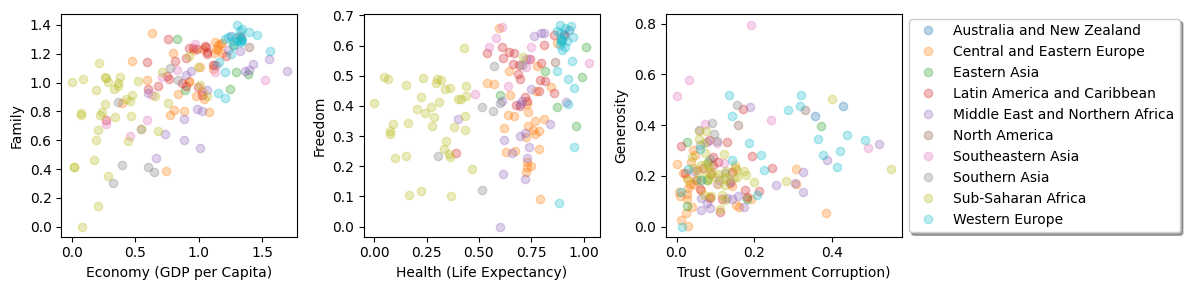

In [4]:
import matplotlib.pyplot as plt

# Index of the attributes to plot the data
i = 0  
j = 1  

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plotting the data
for col in range(3):
    for c in range(C):
        # select indices belonging to class c:
        class_mask = y == c
        axs[col].plot(X[class_mask, i+2*col], X[class_mask, j+2*col], "o", alpha=0.3)
    axs[col].set_xlabel(attributeNames[i+2*col])
    axs[col].set_ylabel(attributeNames[j+2*col])

# Add legend to the right side of the last subplot
axs[2].legend(classNames, loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


So there are not main outliers, but the data is not centered nor normal distributed. Let's do it here and plot the results.

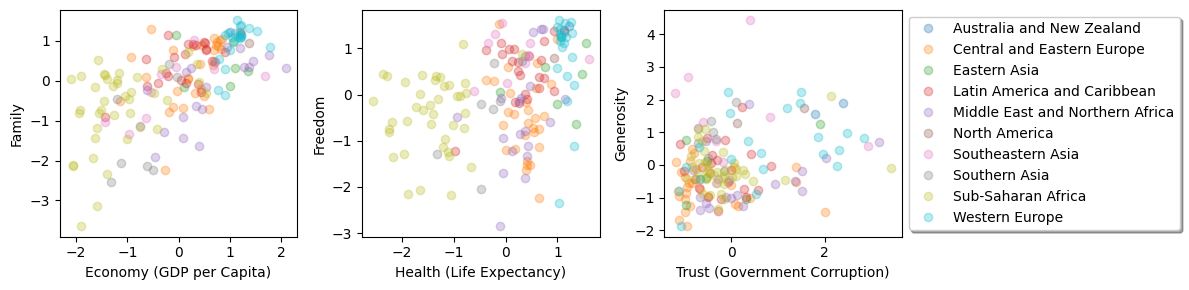

In [5]:
## Let's standardize the data

# Subtract the mean from the data
X = X - np.ones((N, 1)) * X.mean(axis=0)

# Divide by the standard deviation
X = X*(1/np.std(X,0))

# Let's plot the data again to verify that the standardization worked
# Index of the attributes to plot the data
i = 0  
j = 1  

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plotting the data
for col in range(3):
    for c in range(C):
        # select indices belonging to class c:
        class_mask = y == c
        axs[col].plot(X[class_mask, i+2*col], X[class_mask, j+2*col], "o", alpha=0.3)
    axs[col].set_xlabel(attributeNames[i+2*col])
    axs[col].set_ylabel(attributeNames[j+2*col])

# Add legend to the right side of the last subplot
axs[2].legend(classNames, loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Now, the data is standardized. Let's quickly check that it is not correlated.

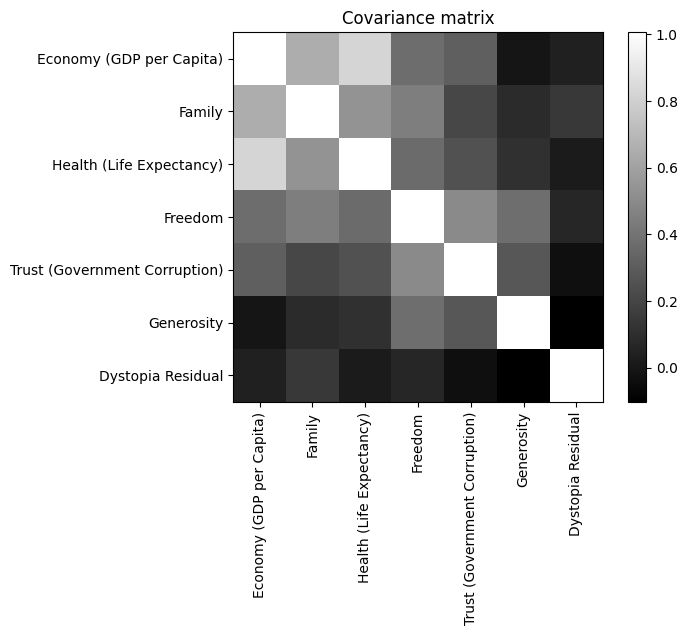

In [6]:
## Let's check the covariance matrix

# Covariance matrix
Cov = np.cov(X, rowvar=False)

# Let's plot the covariance matrix
figure()
imshow(Cov, cmap='gray')
colorbar()
xticks(range(len(attributeNames)), attributeNames, rotation=90)
yticks(range(len(attributeNames)), attributeNames)
title('Covariance matrix')
show()


According to the covariance matrix, there are not two attributes that are explicitely interlinked (covariance close to 1). We can only see that that Economy and Health are a few correlated, which makes sense. However, it seems that it is not a too important correlation, so we can start the PCA.

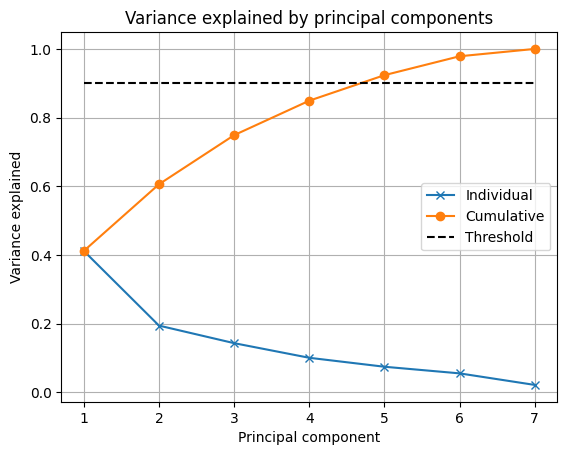

In [7]:
## Plotting the amount of variation explained as a function of the number of PCA components included

# Subtract mean value from data (mean already equal to zero due to standardization)
Y = X - np.ones((N, 1)) * X.mean(axis=0)

# PCA by computing SVD of Y
U, S, V = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()


We can see here that the variance explained of the different principle components is not very high. This might cause some problems for us when we will try to guess from which region is the country. We can still plot the data in the basis of different PCAs to see.

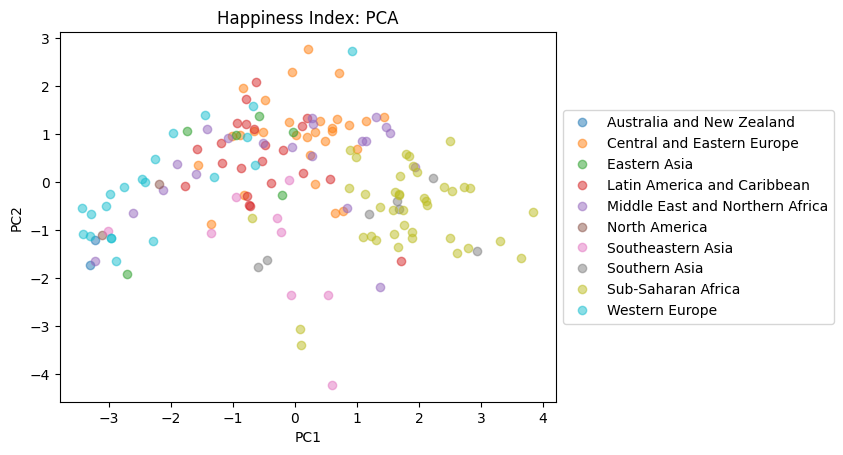

In [8]:
## Let's compute the PCA

# Subtract mean value from data
Y = X - np.ones((N, 1)) * X.mean(0)

# PCA by computing SVD of Y
U, S, Vh = svd(Y, full_matrices=False)
# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Project the centered data onto principal component space
Z = Y @ V

# Indices of the principal components to be plotted
i = 0
j = 1

# Plot PCA of the data
f, ax = plt.subplots()
ax.set_title("Happiness Index: PCA")
for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    ax.plot(Z[class_mask, i], Z[class_mask, j], "o", alpha=0.5)
ax.legend(classNames, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC{0}".format(i + 1))
ax.set_ylabel("PC{0}".format(j + 1))

# Output result to screen
plt.show()


We can see some tendencies, but it is not very clear... For example Sub-Saharan Africa countries have high PC1 one when Western Europe countries have low PC1. Let's see what's hidden behind PCA1.

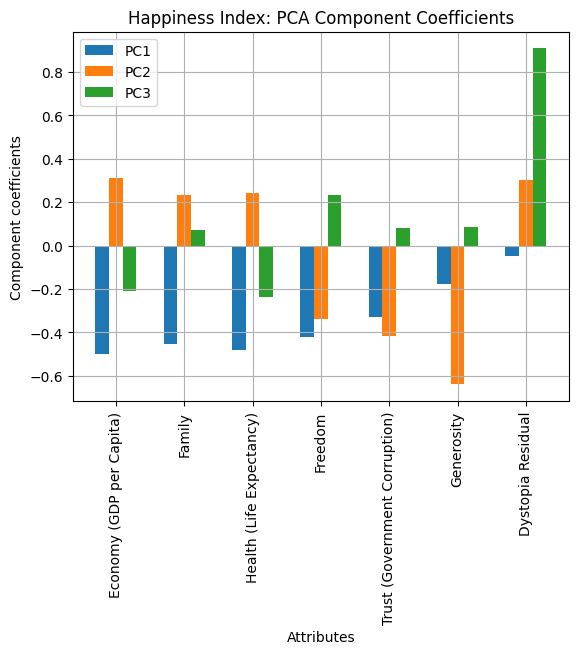

In [9]:
## Let's look at the PCA component coefficients

Y = X - np.ones((N, 1)) * X.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T
N, M = X.shape

# Let's look at their coefficients of the first three principal components:
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
c = ["r", "g", "b"]
bw = 0.2
r = np.arange(1, M + 1)
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw)
plt.xticks(r + bw, attributeNames, rotation = 90)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Happiness Index: PCA Component Coefficients")
plt.show()


According to this plot, we can see that for PC1, countries with high values of Economy, Family, Health, Freedom and Trust will result in low PC1 (Western Europe) while it will be the opposite for the countries with low values (Sub-Saharan Africa)

This was an interesting interpretation of the data, but not 100% convaincing. Let's try to do something which involves higher variance explained

# Second Approch - Classification ( and Regression later): Guessing the Economy (GDP per Capita) of a country
## Using its Family, Health (Life Expectancy), Freedom, Trust (Government Corruption), Generosity and Dystopia Residual

We will basically doc the same steps than in part one. However, we first need to add a new column in our data to indicate if a country has a High, Medium or Low Economy. Later, we will create a regression problem by guessing the value of the economy. For the moment, we are just doing another classification problem by assessing to which category the country belongs.

In [10]:
## Loading the data

# Specify the file path
file_path = 'Data/2015.csv'
doc = []
# Open the CSV file
with open(file_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Each row is a list representing the columns in that row
        doc.append(row)

# Add a column to doc that contains categories for each country based on their Economy (GDP per Capita) score
# The categories should be based on the following Economy (GDP per Capita) scores:
# 0.6 or lower: 'Low'
# Between 0.6 and 1.2: 'Medium'
# 1.2 or higher: 'High'
categories = []
for row in doc[1:]:
    score = float(row[5])
    if score <= 0.6:
        categories.append('Low')
    elif score <= 1.2:
        categories.append('Medium')
    else:
        categories.append('High')
# Add the categories list as a new column in doc
doc[0].append('Categories')
for i, category in enumerate(categories):
    doc[i + 1].append(category)

In [11]:
## Preparing the data for the PCA

# Extract attribute names (1st row, column 6 until 12)
attributeNames = doc[0][6:11]

# Extract class names to python list,
# then encode with integers (dict)
classLabels = [row[12] for row in doc[1:]]  # The class labels are in the first column
classNames = list(set(classLabels))
classNames = sorted(classNames, key=str.lower) # Sort the class names
classDict = dict(zip(classNames,range(len(classNames))))

# Extract vector y containing the name labels and class names of classDict, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(doc[1:]), len(doc[0][6:11])))

# Extract data to X
for i, row in enumerate(doc[1:]):
    X[i, :] = [float(num) for num in row[6:11]]

# Subtract the mean from the data
X = X - np.ones((N, 1)) * X.mean(axis=0)

# Divide by the standard deviation
X = X*(1/np.std(X,0))

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)

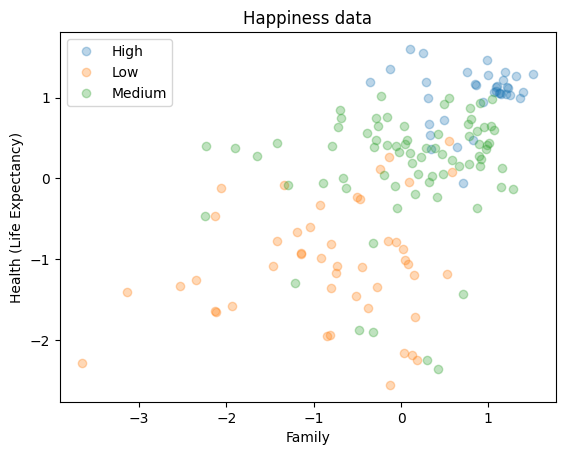

In [12]:
## Plot an example of the data

# Data attributes to be plotted
i = 0
j = 1

f = figure()
title("Happiness data")

for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plot(X[class_mask, i], X[class_mask, j], "o", alpha=0.3)

legend(classNames)
xlabel(attributeNames[i])
ylabel(attributeNames[j])

# Output result to screen
show()

We quickly plot the data to make sure that we have a sufficient amount of data points per catergory. It is all right here. Now let's check the explained variance.

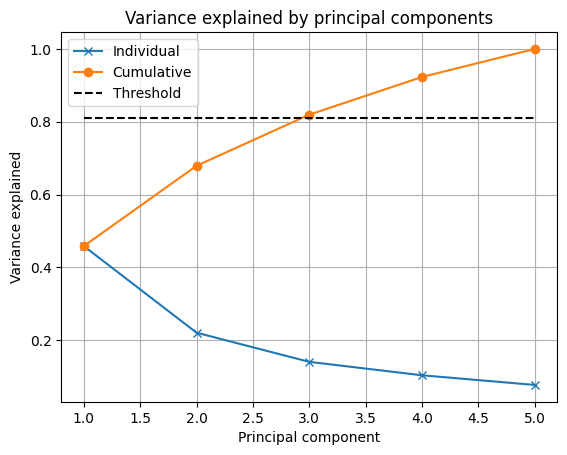

In [13]:
## Plotting the amount of variation explained as a function of the number of PCA components included

# Subtract mean value from data
Y = X - np.ones((N, 1)) * X.mean(axis=0)

# PCA by computing SVD of Y
U, S, V = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

threshold = 0.81

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()


It is a bit better here as we have more than 80% of the explained variance within the three first components.

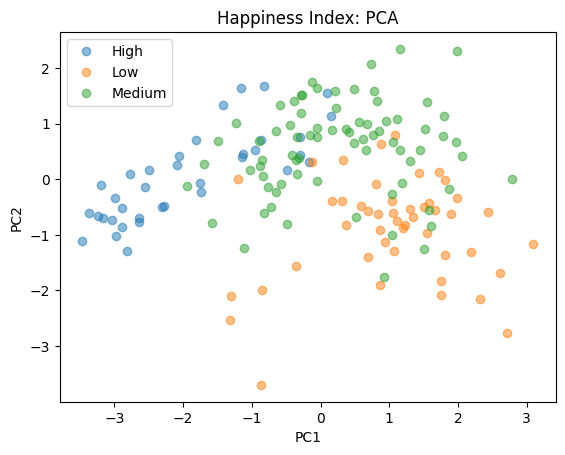

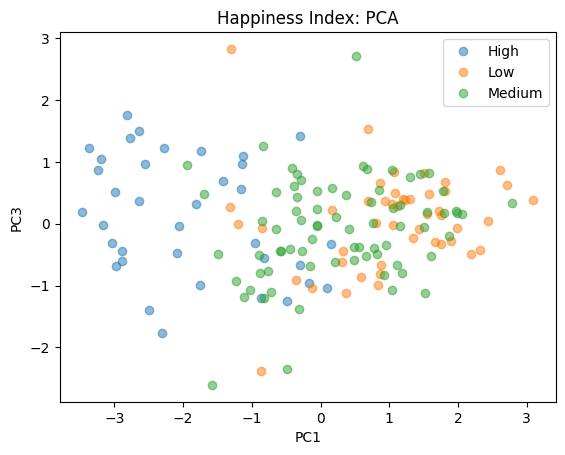

In [14]:
## Plotting the data projected onto the considered principal components

# Subtract mean value from data
Y = X - np.ones((N, 1)) * X.mean(0)

# PCA by computing SVD of Y
U, S, Vh = svd(Y, full_matrices=False)
# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Project the centered data onto principal component space
Z = Y @ V

# Indices of the principal components to be plotted
i = 0
j = 1

# Plot PCA of the data
f = figure()
title("Happiness Index: PCA")
# Z = array(Z)
for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plot(Z[class_mask, i], Z[class_mask, j], "o", alpha=0.5)
legend(classNames)
xlabel("PC{0}".format(i + 1))
ylabel("PC{0}".format(j + 1))

# Output result to screen
show()


# Indices of the principal components to be plotted
i = 0
j = 2

# Plot PCA of the data
f = figure()
title("Happiness Index: PCA")
# Z = array(Z)
for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plot(Z[class_mask, i], Z[class_mask, j], "o", alpha=0.5)
legend(classNames)
xlabel("PC{0}".format(i + 1))
ylabel("PC{0}".format(j + 1))

# Output result to screen
show()

We can see clusters appearing in the graph between PC1 and PC2. Let see what they reprensent.

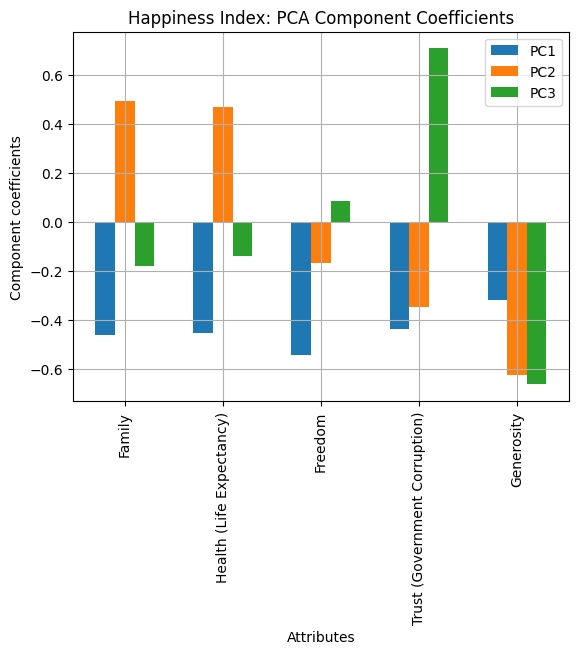

In [15]:
## Plotting the principal directions of the considered PCA components (either find a way to plot them or interpret them in terms of the features)

Y = X - np.ones((N, 1)) * X.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T
N, M = X.shape

# Let's look at the coefficients of the first three principal components:
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
c = ["r", "g", "b"]
bw = 0.2
r = np.arange(1, M + 1)
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw)
plt.xticks(r + bw, attributeNames, rotation = 90)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Happiness Index: PCA Component Coefficients")
plt.show()

We can see that the first principal component is mainly influenced by negative attributes scores.
The second principal component is mainly influenced by positive Family and Health scores, and negative Genersity and Trust scores.
Moreover, using the graphs above, we see that the low Economy category has a high PC1 and low PC2, while the high Economy category has a low PC1 and high PC2.
More conclusions are done in the Part 4 of the report.